[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain (Anthropic Version)

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_anthropic langchain_core langgraph

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [20]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="Are you interested in learning about planets?", name="Model")]
messages.append(HumanMessage(content="Yes, especially Mars.", name="Alex"))
messages.append(AIMessage(content="Mars is fascinating! What would you like to know?", name="Model"))
messages.append(HumanMessage(content="Tell me about the possibility of life on Mars.", name="Alex"))


for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

Are you interested in learning about planets?
================================ Human Message =================================
Name: Alex

Yes, especially Mars.
================================== Ai Message ==================================
Name: Model

Mars is fascinating! What would you like to know?
================================ Human Message =================================
Name: Alex

Tell me about the possibility of life on Mars.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with Anthropic Claude. 

Let's check that your `ANTHROPIC_API_KEY` is set and, if not, you will be asked to enter it.

In [21]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file inside a folder
# Replace 'your_folder_name' with the actual folder name
load_dotenv('studio/.env')

# The API key will now be automatically loaded from your .env file
# Make sure your .env file contains: ANTHROPIC_API_KEY=your-api-key-here

True

We can load a chat model and invoke it with our list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [22]:
from langchain_anthropic import ChatAnthropic

# Using Claude 3.5 Sonnet - you can also use:
# - "claude-3-opus-20240229" for most powerful
# - "claude-3-haiku-20240307" for fastest/cheapest
llm = ChatAnthropic(model="claude-sonnet-4-20250514", temperature=0)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [23]:
result

AIMessage(content="The possibility of life on Mars is one of the most exciting questions in astrobiology! Here's what we know:\n\n**Evidence that makes life possible:**\n- Mars once had liquid water on its surface billions of years ago\n- We've found evidence of ancient riverbeds, lakes, and possibly oceans\n- Mars still has water ice at its poles and likely underground\n- The planet contains organic molecules (carbon-based compounds)\n- Some areas may have had habitable conditions in the past\n\n**Current search efforts:**\n- NASA's Perseverance rover is actively searching for signs of ancient microbial life\n- It's collecting rock samples that will eventually be returned to Earth for detailed analysis\n- Previous missions found methane in Mars' atmosphere, which could potentially indicate biological activity\n\n**Challenges for life:**\n- Mars has a very thin atmosphere and harsh radiation\n- Surface temperatures are extremely cold\n- Any life would most likely be microbial and possi

In [24]:
result.response_metadata

{'id': 'msg_018hqSgpotpf3sH4QAuqqFzD',
 'model': 'claude-sonnet-4-20250514',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0,
   'ephemeral_5m_input_tokens': 0},
  'cache_creation_input_tokens': 0,
  'cache_read_input_tokens': 0,
  'input_tokens': 62,
  'output_tokens': 282,
  'server_tool_use': None,
  'service_tier': 'standard'},
 'model_name': 'claude-sonnet-4-20250514'}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) including Anthropic, and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [38]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [43]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [45]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'toolu_01BukwM8qpEyhnmceBVe2drQ',
  'type': 'tool_call'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [46]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [47]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [48]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [50]:
# Initial state
initial_messages = [
    AIMessage(content="Welcome to the math help desk!", name="Model"),
    HumanMessage(content="Can you help me with calculus?", name="Alex")
]

# New message to add
new_message = AIMessage(content="Of course! What calculus topic are you struggling with?", name="Model")

# Test
add_messages(initial_messages, new_message)


[AIMessage(content='Welcome to the math help desk!', additional_kwargs={}, response_metadata={}, name='Model', id='fdc04ae6-172c-4cf4-9f5d-8abab53c2c64'),
 HumanMessage(content='Can you help me with calculus?', additional_kwargs={}, response_metadata={}, name='Alex', id='66c02714-2fef-4533-a247-959a86aa1f6b'),
 AIMessage(content='Of course! What calculus topic are you struggling with?', additional_kwargs={}, response_metadata={}, name='Model', id='d723213b-f5db-418a-a307-a7dc387250f9')]

## Our graph

Now, let's use `MessagesState` with a graph.

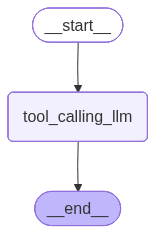

In [51]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [52]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you today? I have access to a multiplication function if you need to multiply any numbers together, or feel free to ask me about anything else!


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [53]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

[{'text': "I'll multiply 2 and 3 for you.", 'type': 'text'}, {'id': 'toolu_018UfxSaGSrbqtf4fiDBDi7M', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_018UfxSaGSrbqtf4fiDBDi7M)
 Call ID: toolu_018UfxSaGSrbqtf4fiDBDi7M
  Args:
    a: 2
    b: 3
